In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import gc
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import anndata as ad
import numpy as np
import yaml
import sys
import h5py
import logging
import scanpy as sc
from os.path import join
import scipy.io as sio
import scipy.sparse as sps
from sklearn.cluster import KMeans

import warnings
def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

from sklearn.metrics import adjusted_rand_score

def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v

def eval_ads(ads, ref_key, src_key):
    aris = []
    for ad in ads:
        aris.append(adjusted_rand_score(ad.obs[src_key], ad.obs[ref_key]))
    return aris

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
def search_louvain(ad, use_rep, n_neighbors=15, n_clusters=5):
    sc.pp.neighbors(ad, n_neighbors=n_neighbors, use_rep=use_rep)
    rs = np.arange(0.1, 1.0, 0.1)
    n_cs = []
    for r in rs:
        sc.tl.louvain(ad, resolution=r, key_added=f'r={r}')
        n_cs.append(ad.obs[f'r={r}'].nunique())
    n_cs = np.array(n_cs)
    if (n_cs==n_clusters).sum() >= 1:
        ri = np.where(n_cs==n_clusters)[0][0]
        ad.obs['louvain_k'] = ad.obs[f'r={rs[ri]}'].to_list()
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(ad.obsm[use_rep])
        ad.obs['louvain_k'] = kmeans.labels_.astype('str')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def load_h5(path):
    with h5py.File(path, 'r') as f:
        print(f['matrix'].keys())
        print(f['matrix']['features'].keys())

        barcodes = [_.decode('utf-8') for _ in f['matrix']['barcodes'][:]]
        data = f['matrix']['data'][:]
        indices = f['matrix']['indices'][:]
        indptr = f['matrix']['indptr'][:]
        shape = f['matrix']['shape'][:]

        feature_type = [_.decode('utf-8') for _ in f['matrix']['features']['feature_type'][:]]
        feature_id   = [_.decode('utf-8') for _ in f['matrix']['features']['id'][:]]
        feature_name = [_.decode('utf-8') for _ in f['matrix']['features']['name'][:]]
        feature_interval = [_.decode('utf-8') for _ in f['matrix']['features']['interval'][:]]


        X = sps.csc_matrix(
            (data, indices, indptr), 
            shape = shape
        ).tocsc().astype(np.float32).T.toarray()

        adata = sc.AnnData(X)
        adata.obs_names = barcodes
        adata.var_names = feature_id
        adata.var['type'] = feature_type
        adata.var['name'] = feature_name
        adata.var['interval'] = feature_interval
    return adata

In [2]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def set_spatial(ad):
    ad.obsm['spatial'] = ad.obs[['array_row', 'array_col']].values
    ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]
    ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
    return ad

In [3]:
def load_zu(_dir):
    zs = []

    for fi in sorted(os.listdir(_dir)):
        dfi = pd.read_csv(join(_dir, fi), header=None)
        zs.append(dfi.values)
    zs = np.vstack(zs)
    z, u = zs[:, :-2], zs[:, -2:]
    return z, u

def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

In [4]:
result_dir = '/disco_500t/xuhua/gitrepo/midas/result'

In [5]:
data_dir = '/disco_500t/xuhua/data/MISAR_seq/'
ad_bridge = load_h5(join(data_dir, 'E15_5-S1_raw_feature_bc_matrix.h5'))
ad_test1 = load_h5(join(data_dir, 'E13_5-S1_raw_feature_bc_matrix.h5'))
ad_test2 = load_h5(join(data_dir, 'E18_5-S1_raw_feature_bc_matrix.h5'))  # inconsistent peak name across batches
peak_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'BaiduDisk/section1/peak_mat.mtx')).T)
peak_spot_name = pd.read_csv(join(data_dir, 'BaiduDisk/section1/peak_spot_names.csv')).x.values

meta = pd.read_csv(join(data_dir, 'BaiduDisk/section1/meta_data.csv'), index_col=0)

ad_bridge.obs_names = [f'E15_5-S1#{_}' for _ in ad_bridge.obs_names]
ad_test1.obs_names = [f'E13_5-S1#{_}' for _ in ad_test1.obs_names]
ad_test2.obs_names = [f'E18_5-S1#{_}' for _ in ad_test2.obs_names]

# split rna and peak
ad_bridge_rna = ad_bridge[:, ad_bridge.var['type'] == 'Gene Expression'].copy()
ad_test1_rna = ad_test1[:, ad_test1.var['type'] == 'Gene Expression'].copy()

# subset peak matrices
bridge_mask = np.in1d(peak_spot_name, ad_bridge.obs_names)
ad_bridge_atac = sc.AnnData(peak_mat[bridge_mask])
ad_bridge_atac.obs_names = peak_spot_name[bridge_mask]
test2_mask = np.in1d(peak_spot_name, ad_test2.obs_names)
ad_test2_atac = sc.AnnData(peak_mat[test2_mask])
ad_test2_atac.obs_names = peak_spot_name[test2_mask]

ad_bridge_rna = subset_ad(ad_bridge_rna, ad_bridge_rna.obs_names.intersection(meta.index))
ad_test1_rna = subset_ad(ad_test1_rna, ad_test1_rna.obs_names.intersection(meta.index))

ad_bridge_rna.obs = meta.loc[ad_bridge_rna.obs_names].copy()
ad_bridge_atac.obs = meta.loc[ad_bridge_atac.obs_names].copy()
ad_test1_rna.obs = meta.loc[ad_test1_rna.obs_names].copy()
ad_test2_atac.obs = meta.loc[ad_test2_atac.obs_names].copy()
ad_bridge_rna = set_spatial(ad_bridge_rna)
ad_bridge_atac = set_spatial(ad_bridge_atac)
ad_test1_rna = set_spatial(ad_test1_rna)
ad_test2_atac = set_spatial(ad_test2_atac)

set_col2cat(ad_bridge_rna, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])
set_col2cat(ad_bridge_atac, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])
set_col2cat(ad_test1_rna, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])
set_col2cat(ad_test2_atac, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])

del peak_mat, ad_bridge, ad_test1, ad_test2
gc.collect()

<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>
<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'interval', 'name']>
<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>
<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'interval', 'name']>
<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>
<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'interval', 'name']>


471

In [6]:
ad_bridge_atac = ad_bridge_atac[ad_bridge_rna.obs_names].copy()
assert (ad_bridge_rna.obs_names == ad_bridge_atac.obs_names).all()

ad_rna_all = sc.concat([ad_bridge_rna, ad_test1_rna])
ad_atac_all = sc.concat([ad_bridge_atac, ad_test2_atac])

sc.pp.highly_variable_genes(ad_rna_all, flavor='seurat_v3', n_top_genes=10000, batch_key='Sample')
hvg_names = ad_rna_all.var.query('highly_variable').index.to_numpy()

# ac.pp.tfidf(ad_atac_all, scale_factor=1e4)
sc.pp.highly_variable_genes(ad_atac_all, flavor='seurat_v3', n_top_genes=50000, batch_key='Sample')

hvp_names = ad_atac_all.var.query('highly_variable').index.to_numpy()

ad_bridge_rna = ad_bridge_rna[:, hvg_names].copy()
ad_bridge_atac = ad_bridge_atac[:, hvp_names].copy()
ad_test1_rna = ad_test1_rna[:, hvg_names].copy()
ad_test2_atac = ad_test2_atac[:, hvp_names].copy()
ad_bridge_rna.shape, ad_bridge_atac.shape

((1949, 10000), (1949, 50000))

In [7]:
def split_list(input_list, chunk_size):
    # Split the list into chunks of size chunk_size
    return [input_list[i:i + chunk_size] for i in range(0, len(input_list), chunk_size)]

In [8]:
### save data
input_train_mod1 = ad_bridge_rna
input_train_mod2 = ad_bridge_atac
input_test_mod1 = ad_test1_rna
input_test_mod2 = ad_test2_atac

tmp_out_dir = f'/disco_500t/xuhua/gitrepo/midas/data/processed/misar_E15-13-18-nPeak-50000'
feat_dir = join(tmp_out_dir, 'feat')
os.makedirs(feat_dir, exist_ok=True)

atac_feat_chunks = split_list(np.arange(input_train_mod2.n_vars), 4000)
input_train_mod2.var_names = np.hstack([[f'chr{i}-{_}-1' for _ in chunk] for i,chunk in enumerate(atac_feat_chunks, 1)])
input_test_mod2.var_names = input_train_mod2.var_names

df_feat_dims = pd.DataFrame(np.array([len(_) for _ in atac_feat_chunks]).reshape(-1, 1), columns=['atac'])
df_feat_dims['rna'] = input_train_mod1.n_vars
df_feat_rna_names = pd.DataFrame(input_train_mod1.var_names, columns=['x'])
df_feat_adt_names = pd.DataFrame(input_train_mod2.var_names, columns=['x'])
df_feat_dims.to_csv(join(feat_dir, 'feat_dims.csv'))
df_feat_rna_names.to_csv(join(feat_dir, 'feat_names_rna.csv'))
df_feat_adt_names.to_csv(join(feat_dir, 'feat_names_atac.csv'))

# each subset
subsets = [[input_train_mod1, input_train_mod2], [input_test_mod1], [input_test_mod2]]
mods = [['rna', 'atac'], ['rna'], ['atac']]

for si in range(3):
    for fname in ['mask', 'mat', 'vec']:
        os.makedirs(join(tmp_out_dir, f'subset_{si}/{fname}'), exist_ok=True)
    tmp_dir = join(tmp_out_dir, f'subset_{si}')
    for ad,mi in zip(subsets[si], mods[si]):
        mat = ad.X.A if sps.issparse(ad.X) else ad.X
        df_mat = pd.DataFrame(mat, index=ad.obs_names, columns=ad.var_names)
        df_mat.to_csv(join(tmp_dir, f'mat/{mi}.csv'))

        os.makedirs(join(tmp_dir, f'vec/{mi}'), exist_ok=True)
        for idx, mati in enumerate(mat):
            pd.DataFrame(mati.reshape(1, -1)).to_csv(join(tmp_dir, 'vec/{}/{:05d}.csv'.format(mi, idx)), header=None, index=None)
        pd.DataFrame(ad.obs_names, columns=['x']).to_csv(join(tmp_dir, 'cell_names.csv'))

        # save mask
        pd.DataFrame(np.ones(ad.n_vars, dtype='int')).to_csv(join(tmp_dir, f'mask/{mi}.csv'))

In [9]:
for e, ep in enumerate([2000], 1):
    training_command = f'CUDA_VISIBLE_DEVICES=2 python run.py --exp e{e} --task misar_E15-13-18-nPeak-50000 --epoch_num {ep}'

    run_command = 'CUDA_VISIBLE_DEVICES=2 python run.py --task misar_E15-13-18-nPeak-50000 --act predict_all_latent_bc --init_model sp_{:08d} --exp e{}'\
                                .format(ep-1, e)
    print(training_command)
    print(run_command)

CUDA_VISIBLE_DEVICES=2 python run.py --exp e1 --task misar_E15-13-18-nPeak-50000 --epoch_num 2000
CUDA_VISIBLE_DEVICES=2 python run.py --task misar_E15-13-18-nPeak-50000 --act predict_all_latent_bc --init_model sp_00001999 --exp e1


/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


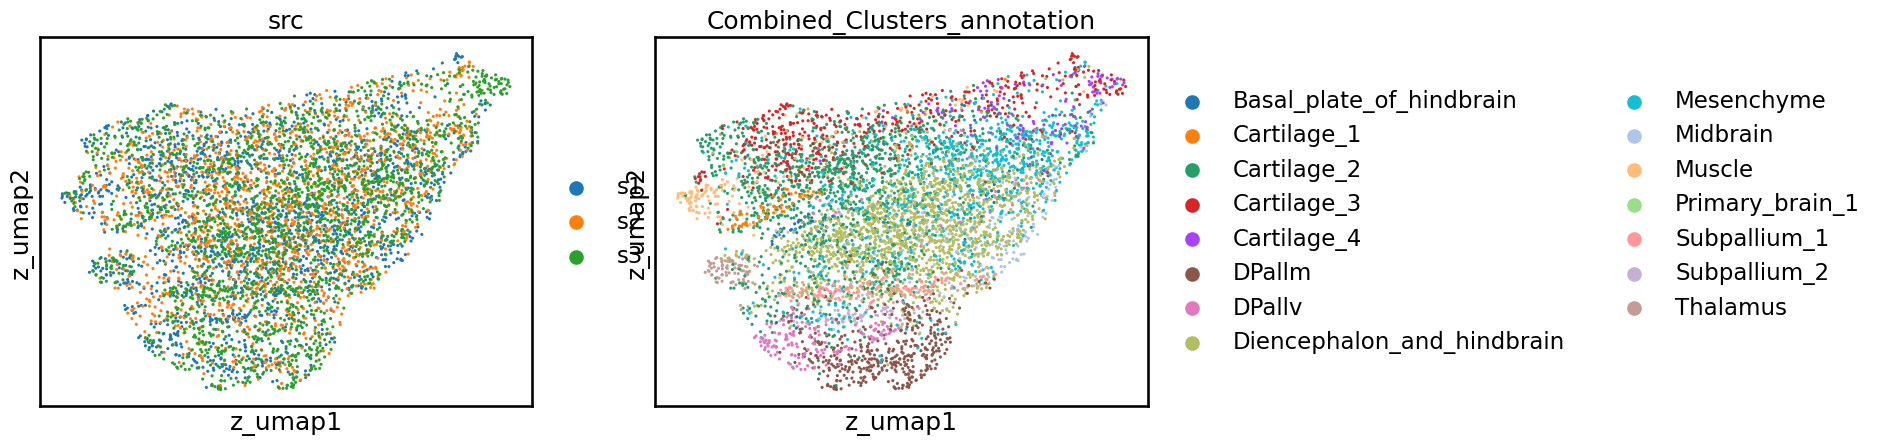

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |                                                                      |   0%

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%


In [10]:
R1, R2, R3, R4 = [], [], [], []
# for e, ep in enumerate([800, 1000, 2000], 1):
e, ep = 1, 2000
model_pt = 'sp_{:08d}'.format(ep-1)

tmp_dir = f'{result_dir}/misar_E15-13-18-nPeak-50000/e{e}/default/predict/{model_pt}'
target_ads = [ad_bridge_rna, ad_test1_rna, ad_test2_atac]
for i in range(3):
    z, u = load_zu(join(tmp_dir, f'subset_{i}/z/joint'))
    target_ads[i].obsm['z'] = z
    target_ads[i].obsm['u'] = u
    
ad_mosaic = sc.concat(target_ads, label='src', keys=['s1', 's2', 's3'])
ad_mosaic = get_umap(ad_mosaic, ['z'])

wrap_warn_plot(ad_mosaic, 'z_umap', ['src', 'Combined_Clusters_annotation'])

try:

    # from sklearn.cluster import KMeans
    # print("mclust failed, try kmeans")
    # kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['z'])
    # ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
    # clust_key = 'kmeans'

    ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='z')  
    clust_key = 'mclust'
   
except:

    # ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='z')  
    # clust_key = 'mclust'

    from sklearn.cluster import KMeans
    print("mclust failed, try kmeans")
    kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['z'])
    ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
    clust_key = 'kmeans'
    
split_ob([ad_bridge_rna, ad_test1_rna, ad_test2_atac], ad_mosaic, ob='obs',  key=clust_key)

In [11]:
ad_mosaic.obs['before_clust'] = ad_mosaic.obs[clust_key].to_list()

In [11]:
### evaluation
from sklearn.metrics import adjusted_rand_score
r1 = eval_ads([ad_mosaic, ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'Combined_Clusters_annotation', clust_key)
print(r1)
R1.append(r1)

lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='z', use_neighbors=False,
)
print(lisi_res['src_iLISI'][0])
R2.append(lisi_res['src_iLISI'][0])

r4 = eval_labelTransfer(ad_test1_rna, ad_test2_atac, 'z', 'Combined_Clusters_annotation', knn=10)
print(r4)
R4.append(r4)

[0.12136193951009797, 0.20106285309050206, 0.047410339405752365, 0.24469878354053795]
0.7651734635110059
0.11661092077754376


### after batch corr

In [13]:
from batchCorr import HARMONY

ad_mosaic.obsm['z_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['z']), ad_mosaic.obs['src'].to_list())
split_ob([ad_bridge_rna, ad_test1_rna, ad_test2_atac], ad_mosaic, ob='obsm', key='z_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [14]:
try:
    # from sklearn.cluster import KMeans
    # print("mclust failed, try kmeans")
    # kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['z_har'])
    # ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
    # clust_key = 'kmeans'

    ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='z_har')  
    clust_key = 'mclust'

except:

    # ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='z_har')  
    # clust_key = 'mclust'

    from sklearn.cluster import KMeans
    print("mclust failed, try kmeans")
    kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['z_har'])
    ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
    clust_key = 'kmeans'

split_ob([ad_bridge_rna, ad_test1_rna, ad_test2_atac], ad_mosaic, ob='obs',  key=clust_key)

fitting ...
  |                                                                      |   0%

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%


In [15]:
ad_mosaic.obs['after_clust'] = ad_mosaic.obs[clust_key].to_list()

In [15]:
r1 = eval_ads([ad_mosaic, ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'Combined_Clusters_annotation', clust_key)
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='z_har', use_neighbors=False,
)
r2 = lisi_res['src_iLISI'][0]

r4 = eval_labelTransfer(ad_test1_rna, ad_test2_atac, 'z_har', 'Combined_Clusters_annotation', knn=10)

In [16]:
r1, r2, r4

([0.11935106027736249,
  0.1986051805382822,
  0.046597132260022274,
  0.21775239099267235],
 0.8190379072141016,
 0.11444626256997409)

In [16]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/misar_seq/E15-13-18/midas'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['z'], index=ad_mosaic.obs_names.to_list())
df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['z_har'], index=ad_mosaic.obs_names.to_list())
df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))